# Batch request 1


The vertical rate of an aircraft refers to its rate of climb or descent, typically measured in meters per second (m/s). It tells you how fast the aircraft is moving vertically — whether it's ascending (positive value) or descending (negative value). A rolling average of vertical rate is the average of vertical rate over a sliding window of time, commonly used to smooth out fluctuations and make trends easier to analyze.

Calculating the rolling average of vertical rate for all airplanes can provide insights into overall air traffic trends, such as periods of collective ascent or descent across multiple planes. It helps detect anomalies or patterns in vertical movement that may indicate weather changes, air traffic congestion, or large-scale operational shifts. This aggregate data can assist in monitoring traffic flow, ensuring safety, and identifying potential issues that affect multiple aircraft at once.

## Imports

In [62]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import from_json, col, window, avg, count
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, FloatType
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md

In [63]:
conf = SparkConf() \
    .setAppName('SparkApp') \
    .setMaster('spark://spark:7077') \
    .set("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4,org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.3") \
    .set("spark.sql.shuffle.partitions", "10")
 

sc = SparkContext.getOrCreate(conf=conf)

from pyspark.sql import SQLContext
sql_context = SQLContext(sc)

/opt/conda/lib/python3.12/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
# Kafka configuration
kafka_broker = "kafka1:9092"
kafka_topic = "opensky"

schema = StructType([
    StructField("icao24", StringType(), True),
    StructField("callsign", StringType(), True),
    StructField("origin_country", StringType(), True),
    StructField("time_position", IntegerType(), True),
    StructField("on_ground", StringType(), True),
    StructField("velocity", FloatType(), True),
    StructField("vertical_rate", FloatType(), True), 
])

# Read raw data from Kafka for batch processing
raw_stream = sql_context.read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafka_broker) \
    .option("subscribe", kafka_topic) \
    .option("startingOffsets", "earliest") \
    .load()

# Parse Kafka messages
parsed_stream = raw_stream.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema).alias("data")) \
    .select(
        col("data.icao24").alias("icao24"),
        col("data.callsign").alias("callsign"),
        col("data.origin_country").alias("origin_country"),
        (col("data.time_position").cast(TimestampType()).alias("time_position")),
        col("data.velocity").cast(FloatType()).alias("velocity"),
        col("data.vertical_rate").cast(FloatType()).alias("vertical_rate"),  # Use vertical_rate
        col("data.on_ground").alias("on_ground")
    ) \
    .filter(col("data.velocity").isNotNull() & (col("data.on_ground") == "false"))

parsed_stream = parsed_stream.filter(col("data.vertical_rate") > 0)  # Keep valid values only

processed_stream = parsed_stream.withWatermark("time_position", "5 minutes")  # Use time_position as the watermark column

# Perform rolling average over a 5-minute window for vertical_rate
rolling_avg_df = parsed_stream \
    .groupBy(window(col("time_position"), "5 minutes")) \
    .agg(
        avg("vertical_rate").alias("rolling_avg_vertical_rate"),  # Rolling average of vertical_rate
        count("icao24").alias("num_flights")  # Count number of flights in the window
    ) \
    .select(
        col("window.start").alias("window_start"),
        col("window.end").alias("window_end"),
        col("rolling_avg_vertical_rate"),
        col("num_flights")
    )

# Collect the result as a Pandas DataFrame
pandas_df = rolling_avg_df.toPandas()
print(pandas_df)


25/03/21 14:58:06 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


In [ ]:
print(pandas_df.head())
print(pandas_df.dtypes)


         window_start          window_end  rolling_avg_vertical_rate  \
0 2025-03-21 14:10:00 2025-03-21 14:15:00                   8.450000   
1 2025-03-21 14:35:00 2025-03-21 14:40:00                   4.685663   
2 2025-03-21 14:40:00 2025-03-21 14:45:00                   4.553518   
3 2025-03-21 14:20:00 2025-03-21 14:25:00                   9.306897   
4 2025-03-21 14:50:00 2025-03-21 14:55:00                   4.563130   

   num_flights  
0            6  
1         2850  
2         5626  
3           29  
4         5464  
window_start                 datetime64[ns]
window_end                   datetime64[ns]
rolling_avg_vertical_rate           float64
num_flights                           int64
dtype: object


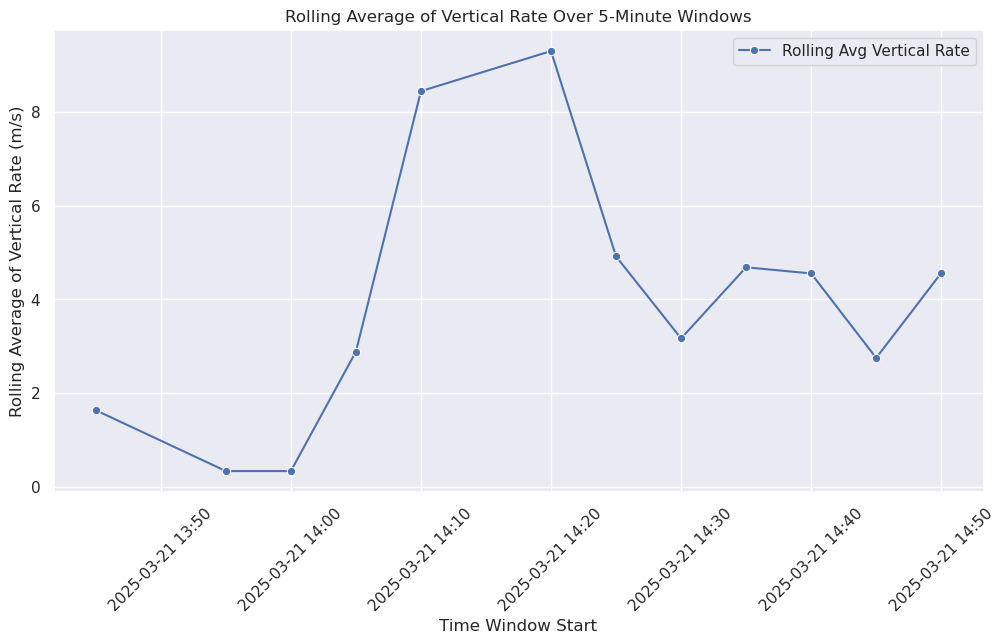

In [ ]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=(12, 6))

# Use 'window_start' for x-axis and 'rolling_avg_vertical_rate' for y-axis
sns.lineplot(x="window_start", y="rolling_avg_vertical_rate", data=pandas_df, marker="o", label="Rolling Avg Vertical Rate")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

ax = plt.gca()
ax.xaxis.set_major_formatter(md.DateFormatter("%Y-%m-%d %H:%M"))  # Show full date and time

plt.xlabel("Time Window Start")
plt.ylabel("Rolling Average of Vertical Rate (m/s)")
plt.title("Rolling Average of Vertical Rate Over 5-Minute Windows")
plt.legend()

plt.show()
